# LargeSampleReport

[large_sample.pdf](https://docs.google.com/spreadsheets/d/1w-eGo7Rep4QbhUl5yfNXdrHs_yOqRhpn7XmwICC9CXg/edit?usp=sharing) is a uniform sample of 1595 pages from the corpus. It is uniform in the sense that each document is equally likely to be selected, and one page is selected uniformly at random from each selected document. See [DatasetMake](https://colab.research.google.com/drive/1hecjNtzXYPeVmIwgKd8uNKDklhTTYZo9?usp=sharing) for motivation and context.

**WARNING:** Be careful about re-running the sections of the notebook that use bootstrapping. The problem isn't that the results aren't replicable (technically, they aren't, but for our purposes they essentially are). It is just that those parts of the notebook will take on the order of minutes to run.

In [156]:
# The capture command is used here to minimize visual clutter.
%%capture
!sudo apt-get install tesseract-ocr-all
!pip3 install pytesseract
!pip install langdetect
!pip install PyMuPDF

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [150]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr


In [178]:
import tesseract_manager

In [7]:
auth.authenticate_user()
GC = gspread.authorize(GoogleCredentials.get_application_default())

In [8]:
def get_df(title, gc, worksheet=0, has_headers=True):
    """Returns a pandas.DataFrame representation of the
    (WORKSHEET)th worksheet of the Google Sheets (GSHEET)
    file that has title TITLE.
    """
    contents = gc.open(title).get_worksheet(worksheet).get_all_values()
    if has_headers:
        return pd.DataFrame.from_records(
            data=contents[1:],
            columns=contents[0]
        )
    return pd.DataFrame.from_records(contents)

In [9]:
data = get_df('large_sample_page', GC)

## Columns J-O

These columns were created and manually analyzed by Peter from 5/29/2021 to 6/5/2021 and are currently being reviewed by Adam Anderson as of 6/5/2021. Peter chose these fields based on the types of errors that featured most prominently in the development set. The fields are as follows:
* `true_orientation` (as opposed to detected orientation provided by Tesseract via our `tesseract_manager` package)
* `true_language` (as opposed to detected orientation provided by LangDetect via our `tesseract_manager` package): This is the dominant language: The language that is likely preferred by the intended audience of the page.
* `image`: If there are ANY images, however small, this value is TRUE.
* `cuneiform`: Set to TRUE if there are ANY  renderings (photographic or otherwise) of cuneiform script.
* `translit`: Set to TRUE if there is any transliterated cuneiform.
* `mix_lang`: Set to true if multiple languages (excluding IPA transliteration) appear as more than just a few scattered words.

### `true_orientation`

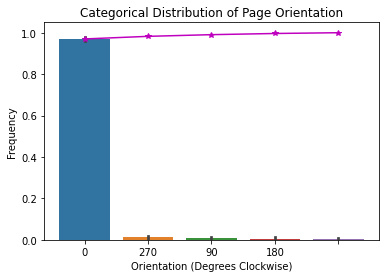

In [59]:
def bar(series, confidence=0.95):
  """Displays a bar chart showing the categorical distribution of SERIES
  in descending order and returns the resulting axes object.
  """
  categories = list(series.unique())
  x = list()
  y = list()
  for value in series:
    for category in categories:
      x.append(category)
      y.append(1 if category == value else 0)
  frequencies = {
      c: sum(y[i] for i, a in enumerate(x) if a == c) / len(series)
      for c in categories
  }
  categories.sort(key=(lambda c: frequencies[c]), reverse=True)
  ax = sns.barplot(
      x=x,
      y=y,
      ci=confidence*100,
      order=categories,
  )
  ax.set_ylabel('Frequency')
  ax.plot(range(len(categories)), [
      sum(frequencies[c] for c in categories[:i+1])
      for i in range(len(categories))
      ], 'm', marker='*', linestyle='solid')
  return ax
ax = bar(data.true_orientation, confidence=0.99)
ax.set_xlabel('Orientation (Degrees Clockwise)')
ax.set_title('Categorical Distribution of Page Orientation');

In [8]:
def boot(series, statistic, n=100000):
  values = list()
  for _ in range(n):
    sample = series.sample(frac=1, replace=True)
    values.append(statistic(sample))
  return values
ab_test = boot(
    data.true_orientation,
    statistic=(
        lambda s: (sum(s == '270') - sum(s == '90')) / len(s.index)
    )
)

In [71]:
def frequencies(series, confidence=0.95, n_boot=10000):
  alpha = 1 - confidence
  counts = series.value_counts()
  frequencies = counts / len(series.index)
  boot_results = [
      boot(series,
           lambda seq: (sum(1 if s == a else 0 for s in seq) / len(seq)),
           n_boot)
      for a in counts.index
  ]
  lower = [
           np.percentile(boot_results[i], alpha / 2 * 100)
           for i in range(len(boot_results))
  ]
  upper = [
           np.percentile(boot_results[i], 100 - alpha / 2 * 100)
           for i in range(len(boot_results))
  ]
  return pd.DataFrame(
      data={
          'count': counts,
          'frequency': frequencies,
          '{:.0f}% CI Lower'.format(confidence * 1e2): lower,
          '{:.0f}% CI Upper'.format(confidence * 1e2): upper,
          },
      index=frequencies.index
  )
frequencies(data.true_orientation)

,count,frequency,95% CI Lower,95% CI Upper
0,1549,0.969944,0.961177,0.978084
270,20,0.012523,0.007514,0.018159
90,13,0.008140,0.004383,0.013150
180,9,0.005636,0.002505,0.009393
,6,0.003757,0.001252,0.006888


Could some bias against recognition of 90 degree rotations have been introduced by the program used in the automatic first pass over the data? This is possible since Tesseract is able to read documents rotated 90 degrees clockwise with no trouble, causing my program to neglect the use of OSD in those cases.

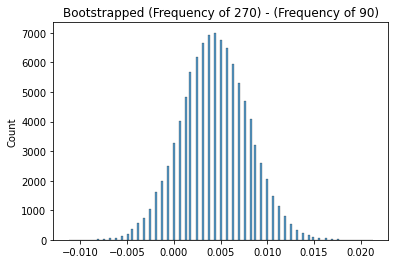

In [9]:
ax = sns.histplot(data=ab_test)
ax.set_title('Bootstrapped (Frequency of 270) - (Frequency of 90)');

In [10]:
2 * sum(x < 0 for x in ab_test) / len(ab_test) # Two-tailed p

0.18628

This is not close to being significant. Now, this test really was not necessary -- the confidence intervals make it obvious that the difference in frequency is not significant.

More importantly, it is now evident that rotated pages are rather uncommon in this dataset. The true frequency of rotated pages could be arbitrarily close to zero, and in any case it probably is not greater than about 5.5 percent. The true value is estimated to be 3 percent.

We may be able to use this data to create prior probabilities; however, this is complicated because Tesseract may have priors implicitly or explicitly encoded in it.

In [11]:
data.mean_confidence = data.apply(
    lambda row: '' if row.mean_confidence == '' else float(row.mean_confidence),
    axis=1
)

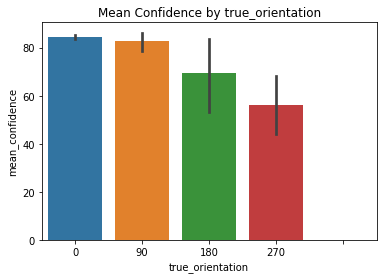

In [84]:
def mean_confidence_bar(data, x):
  """Displays a bar chart of the mean confidence distribution according to
  the categorical variable X.
  """
  counts = data[x].value_counts()
  categories = [c for c in data[x].unique() if counts[c] > 1]
  categories.sort(
      key=lambda c: data[(data[x] == c) & (data.mean_confidence != '')
         ].mean_confidence.mean(),
      reverse=True
  )
  ax = sns.barplot(
      x=x,
      y='mean_confidence',
      data=data[data.mean_confidence != ''],
      order=categories
      )
  ax.set_title('Mean Confidence by {}'.format(x))
  return ax
mean_confidence_bar(data, 'true_orientation');

Regrettably, it seems evident that Tesseract's OSD feature has not solved the orientation problem. Although the confidence difference between 0 and 90 (and perhaps 180 degree) rotations may not be significant, it is clear that 270 degree rotations are not handled well. All that we would need to do to circumvent this would be to run Tesseract twice -- once in the original orientation and once rotated by 180 degrees -- and then we would likely get good accuracy, since Tesseract works for 2 different orientations. But we would have to do this in a way that does not give an unacceptable slowdown.

### `true_language`

The language abbreviations used here are borrowed from [Tesseract](https://tesseract-ocr.github.io/tessdoc/Data-Files-in-different-versions.html).

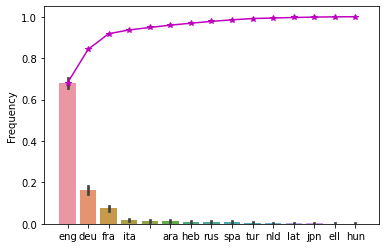

In [60]:
bar(data.true_language);

In the above chart, we can see that although the top 3 languages are by far the most common, perhaps the 9 most common languages (up to Turkish) combined cover most of the corpus.

In [87]:
frequencies(data.true_language)

,count,frequency,95% CI Lower,95% CI Upper
eng,1087,0.680651,0.657483,0.703193
deu,258,0.161553,0.143394,0.179712
fra,121,0.075767,0.063244,0.088917
ita,29,0.018159,0.011897,0.025047
,19,0.011897,0.006888,0.017533
ara,18,0.011271,0.006262,0.016907
heb,15,0.009393,0.005009,0.014402
rus,14,0.008766,0.004383,0.013776
spa,12,0.007514,0.003757,0.011897
tur,10,0.006262,0.002505,0.010645


I note that Greek ("ell") is actually rather uncommon -- so uncommon that ignoring it altogether might not greatly affect our OCR accuracy overall.

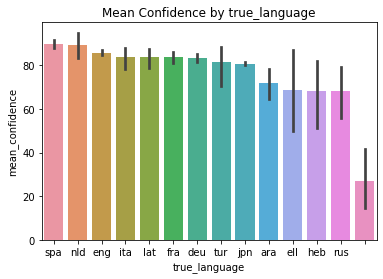

In [85]:
mean_confidence_bar(data, 'true_language');

The set of the five languages associated with the lowest OCR confidence is equal to the set of all found languages that use a script other than Latin.

### `image`

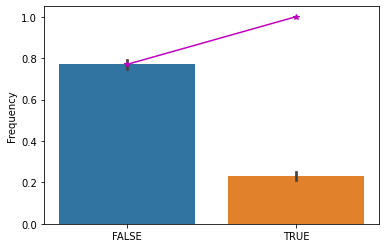

In [88]:
bar(data.image);

In [91]:
frequencies(data.image, n_boot=100000)

,count,frequency,95% CI Lower,95% CI Upper
FALSE,1229,0.769568,0.748904,0.790232
TRUE,368,0.230432,0.209768,0.251096


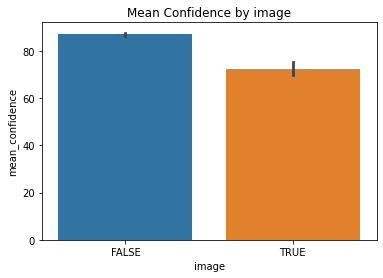

In [90]:
mean_confidence_bar(data, 'image');

Presence of an image is associated with a statistically significant decrease in OCR confidence. This suggests that erasure of images may be an easy way to achieve considerable accuracy improvement.

### `cuneiform`

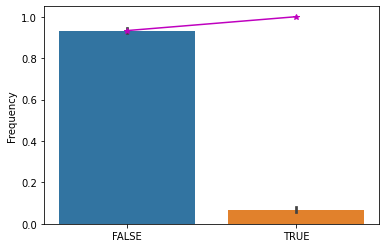

In [92]:
bar(data.cuneiform);

In [93]:
frequencies(data.cuneiform, n_boot=100000)

,count,frequency,95% CI Lower,95% CI Upper
FALSE,1490,0.932999,0.920476,0.944897
TRUE,107,0.067001,0.055103,0.079524


About seven percent of the sampled pages include cuneiform.

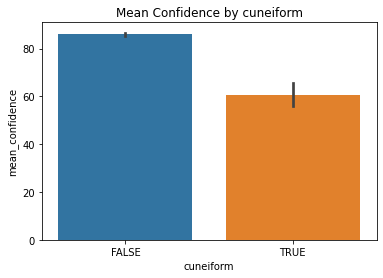

In [94]:
mean_confidence_bar(data, 'cuneiform');

This is unsurprising, and it is harder to resolve than the image problem because it may be nontrivial to distinguish between cuneiform and text. However, we can be sure that cuneiform will almost always be OCR'd with low confidence, so we can use that fact to filter cuneiform out.

We will also likely have more success with `langdetect` if the text we provide to it had low-confidence words filtered out.

### `translit`

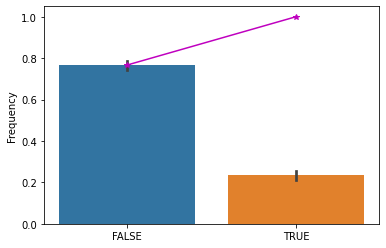

In [95]:
bar(data.translit);

In [96]:
frequencies(data.translit, n_boot=100000)

,count,frequency,95% CI Lower,95% CI Upper
FALSE,1224,0.766437,0.745773,0.787101
TRUE,373,0.233563,0.212899,0.254853


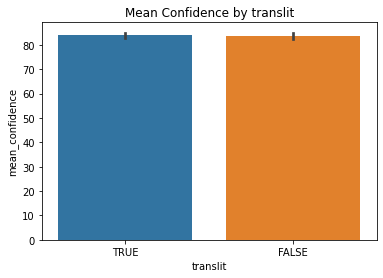

In [97]:
mean_confidence_bar(data, 'translit');

No significant difference in mean confidence by page -- this is unexpected. We should investigate whether transliterated words in particular are detected with lower confidence than non-transliterated words. It is possible that they are, but that because only a few transliterated words might appear on a given page, they did not have a powerful enough effect to be reflected in this analysis.

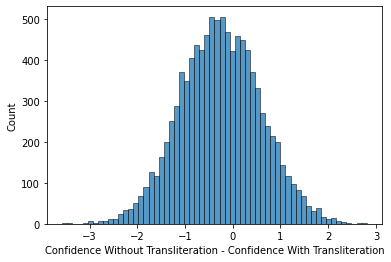

In [108]:
def translit_conf_diff(data):
  return (data[(data.translit == 'FALSE') & (data.mean_confidence != '')
             ].mean_confidence.mean()
         - data[(data.translit == 'TRUE') & (data.mean_confidence != '')
             ].mean_confidence.mean())
ax = sns.histplot(boot(data, translit_conf_diff, 10000));
ax.set_xlabel('Confidence Without Transliteration - Confidence With Transliteration');

### `mix_lang`

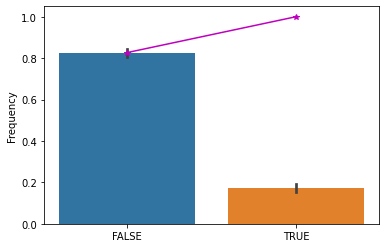

In [98]:
bar(data.mix_lang);

In [99]:
frequencies(data.mix_lang, n_boot=100000)

,count,frequency,95% CI Lower,95% CI Upper
FALSE,1320,0.82655,0.807765,0.844709
TRUE,277,0.17345,0.155291,0.192235


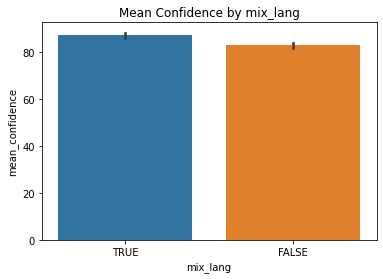

In [100]:
mean_confidence_bar(data, 'mix_lang');

## Columns Q-T: Bib, Fm, Abb, Two

## Sampling

Here, I determine an appropriate stratified sample for the purpose of OCR system evaluation.

In [158]:
class TextAccuracyEstimator:
  """Specifies the logic required to estimate the proportion of
  words correctly read. (Ultimately, it is up to the user to
  determine correctness.)
  """
  def __init__(self, root, text, random):
    """Initializes a TextAccuracyEstimator that analyzes the
    accuracy of the output produced by TEXT.
    ROOT - the directory in which TEXT and its corresponding images
           live
    TEXT - the Text object that managed the analysis of the images
    RANDOM - the Numpy default_random object that determines the
           samples taken by this TextAccuracyEstimator
    """
    self.accuracies = list()
    self._text = text
    self._page_paths = [
        os.path.join(root, 'images', path) for path in self._text.page_paths
        if path.endswith('ppm')
    ]
    self.random = random
  def run(self, n):
    """Collects accuracy data based on N requests for user
    input.
    """
    while len(self.accuracies) < n:
      page_idx = self.random.integers(len(self._page_paths))
      metadata = self._text.page_metadata[page_idx]
      page = Image.open(self._page_paths[page_idx])
      word_idx = self.random.choice(metadata.index)
      row = metadata.loc[word_idx]
      if (pd.isna(row.text)):
        continue
      fig, axes = plt.subplots(1, 4)
      fig.set_figwidth(15)
      for i in range(4):
        if row.left < page.size[0] and row.top < page.size[1]:
          word = page.crop(
                (row.left, row.top, row.left+row.width, row.top+row.height))
          try:
            axes[i].imshow(word)
          except:
            warnings.warn('Could not render {}'.format(str(word)))
        page = page.rotate(90, expand=True)
      plt.show(block=False)
      plt.pause(0.1)
      display(Markdown('<h1>&nbsp;&nbsp;&nbsp;&nbsp;{}</h1>'.format(row.text)))
      self.accuracies.append('y' in input('Is this correct (y/n)?\n').lower())
  def mean(self):
    """Returns the estimated mean accuracy for this text."""
    return sum(self.accuracies) / len(self.accuracies)
class CrossTextAnalysis:
  """Manages and captures data generated from the analysis
  of OCR output across texts in a directory.
  """
  def __init__(self, root, random):
    """Initializes a CrossTextAnalysis object that stores
    accuracy data from Texts found in ROOT and its
    subdirectories.
    ROOT - the directory in which to search for Texts
    RANDOM - the Generator object that determines sampling
           behavior
    """
    self.root = root
    self.random = random
    self.texts = list()
    self.accuracy_estimators = list()
  def run(self, n):
    """Collects accuracy data by taking N sample words from each
    Text in ROOT.
    """
    for text, dir in get_texts(self.root):
      self.texts.append(text)
      estimator = TextAccuracyEstimator(dir, text, self.random)
      self.accuracy_estimators.append(estimator)
      estimator.run(n)
  def accuracies(self):
    """Returns the sequence of estimated accuracies across texts.
    """
    return [estimator.mean() for estimator in self.accuracy_estimators]
  def mean(self):
    """Returns the mean accuracy across texts, such that each
    texts has equal weight regardless of its size.
    """
    return sum(self.accuracies()) / len(self.accuracy_estimators)
  def hist(self):
    """Displays a the frequency distribution of accuracies across
    texts.
    """
    plt.hist(self.accuracies())
    plt.xlabel('Accuracy')
    plt.title('Distribution of OCR Accuracy by Text')
    plt.show(block=False)

In [159]:
with open('correctness_check_results.pickle', 'rb') as dbfile:
  correctness_check = pickle.load(dbfile)
correctness_check

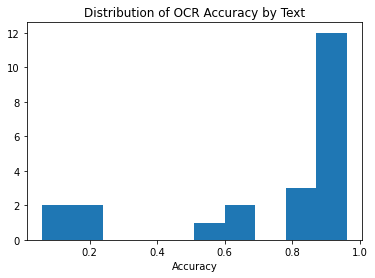

In [163]:
correctness_check.hist()

In [169]:
correctness_check.texts[0].languages.items[0]

'ara'

In [179]:
tesseract_manager.mean_conf(correctness_check.texts[0].page_metadata[0])

55.3125

In [182]:
correctness_check.accuracies()[0]

0.79

In [189]:
confs = np.array([
  sum(tesseract_manager.mean_conf(d) for d in text.page_metadata
      ) / len(text.page_metadata)
  for text in correctness_check.texts
])
accuracies = correctness_check.accuracies()

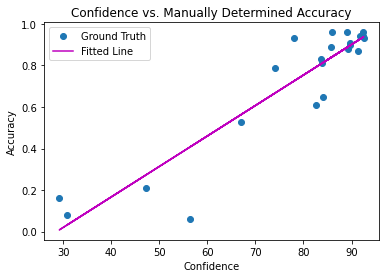

In [198]:
res = stats.linregress(confs, accuracies)
plt.plot(confs, accuracies, 'o', label='Ground Truth')
plt.plot(confs, res.intercept + res.slope * confs, 'm', label='Fitted Line')
plt.ylabel('Accuracy')
plt.xlabel('Confidence')
plt.title('Confidence vs. Manually Determined Accuracy')
plt.legend();

In [199]:
res.rvalue, res.stderr

(0.9234153382526147, 0.0013654579335859677)

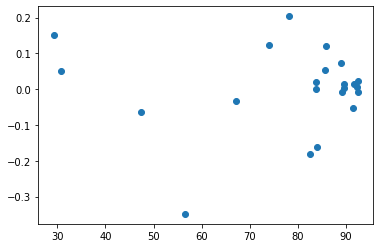

In [211]:
residuals = np.array(accuracies) - (res.intercept + res.slope * confs)
plt.scatter(confs, residuals);

This actually does seem like an acceptable linear fit.

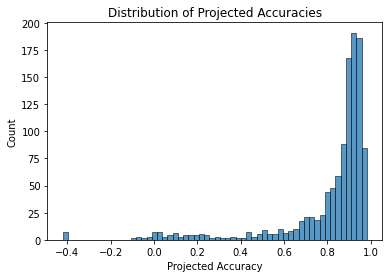

In [225]:
projected_accuracies = (
    res.intercept
    + data[data.mean_confidence != ''].mean_confidence * res.slope
)
ax = sns.histplot(projected_accuracies)
ax.set_title('Distribution of Projected Accuracies')
ax.set_xlabel('Projected Accuracy');

In [206]:
projected_accuracies.std()

0.23527053804113607

In [205]:
ci_width = 0.06
n = (projected_accuracies.std() * stats.norm.ppf(0.975) * 2 / ci_width) ** 2
n

236.25921898032573

Now. This is a little bit tricky. I probably really do need about 236 pages of ground truth in order to have an estimator that is a) unbiased, and b) acceptably precise. But to get that many pages correct would be time-consuming.

But hang on. This doesn't take into account the different weights given to the different pages. It seems likely that many of the outliers are from pages that actually have relatively few words. But how do I get my hands on this difference in variance?

In [244]:
global_accuracies = boot(
    pd.DataFrame(data={
        'projected_accuracy': projected_accuracies,
        'n_words': [
           len(text.split()) for text in data[data.mean_confidence != ''].text
        ]
    }),
    lambda df: df.apply(
        (lambda row: row.n_words * row.projected_accuracy),
        axis=1
        ).sum() / df.n_words.sum(),
    n=1000
)

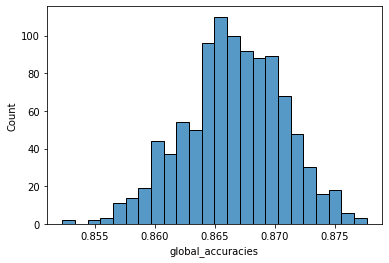

In [246]:
ax = sns.histplot(data=global_accuracies)
ax.set_xlabel('global_accuracies');

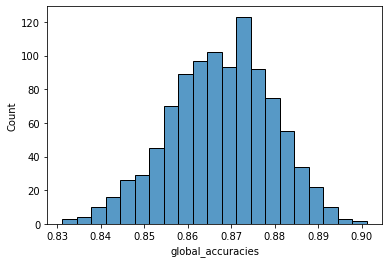

In [247]:
global_accuracies = boot(
    pd.DataFrame(data={
        'projected_accuracy': projected_accuracies,
        'n_words': [
           len(text.split()) for text in data[data.mean_confidence != ''].text
        ]
    }).sample(100),
    lambda df: df.apply(
        (lambda row: row.n_words * row.projected_accuracy),
        axis=1
        ).sum() / df.n_words.sum(),
    n=1000
)
ax = sns.histplot(data=global_accuracies)
ax.set_xlabel('global_accuracies');

In [250]:
lower, upper = np.percentile(global_accuracies, 2.5), np.percentile(global_accuracies, 97.5)
lower, upper, upper - lower

(0.8432706373809528, 0.8886478070295544, 0.04537716964860161)

This shows that an acceptably narrow confidence interval for accuracy might be produced if we weight according to number of words (as originally planned). Of course, this is a little bit messy, since accuracy isn't exactly the metric that I wish to use in the end -- I'm only using it because the only data we have is for accuracy. It may well be the case that I have tinkered with the numbers until they have told me what I want to believe.

But in any case, it almost does not matter: I do not wish to curate a test set with more than about one hundred pages. So I will make a one hundred page test set, and then what must happen will happen. I will accept the confidence intervals that I am able to get.

In [12]:
def optimal_sample(data, x, n):
  data = data[data.mean_confidence != '']
  value_counts = data[x].value_counts()
  def total_words(data, x, c): # This is the weight given to class c.
    return data[data[x] == c].apply(
        lambda row: len(row.text.split()), axis=1).sum()
  # It should make no difference that I take the STD of the mean_confidence
  # rather than the expected accuracy (because the fitted relationship is
  # linear, and constant scales will be normalized out anyway).
  ret = {
      c: total_words(data, x, c) * data[data[x] == c].mean_confidence.std()
      for c in value_counts.index
      if value_counts[c] > 1
  }
  total = sum(ret[c] for c in ret)
  for c in ret:
    ret[c] = round(ret[c] * n / total)
  return ret
optimal_sample(data, 'true_language', 100)

{'': 1,
 'ara': 1,
 'deu': 18,
 'ell': 0,
 'eng': 67,
 'fra': 8,
 'heb': 1,
 'ita': 2,
 'jpn': 0,
 'lat': 0,
 'nld': 0,
 'rus': 1,
 'spa': 0,
 'tur': 1}